In [71]:
import os
import Consts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
sns.set_theme(style="whitegrid")
# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pancancer Report

In [72]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Report Summary
### Example of extracted data:

In [106]:
# read df and join them
df_files = ['lorsi_report.csv']
for i,df_file in enumerate(df_files):
    if i == 0:
        df = pd.read_csv(os.path.join(Consts.PATH_RESULT,df_file))
    else:
        df = df.append(pd.read_csv(os.path.join(Consts.PATH_RESULT,df_file)))  
        
# drop columns and reset indexes
df = df.reset_index()
df = df.drop(columns=['Unnamed: 0','index'])
df = df.drop_duplicates()

# count initial genes in each cancer type
dic_count_genes = {}
for cancer in df["cancer type"].unique():
    dic_count_genes[cancer] =  len(df[df["cancer type"] == cancer])

# all genes that not passes delta with alpha size
mask_stable = (df["max k changes to stay stable"].isna()) & (df['max k changes with chosen alpha'].notna())
mask_unstable = (df["max k changes to stay stable"].notna()) & (df['max k changes with chosen alpha'].notna())
column_name = 'label'
df.loc[mask_stable, column_name] = 'stable'
df.loc[mask_unstable, column_name] = 'unstable'

# upadate masks
mask_stable = df['label'] == 'stable'
mask_unstable = df['label'] == 'unstable'

# change coulumn name "Lorsi p-value" to "orignal p-value"
df.rename(columns = {'Lorsi p_value' : 'Original P-value'}, inplace = True)

df.head()

,cancer type,gene,Article p_value,R p_value,Original P-value,num of samples,better group survival,delta tested,max k changes with chosen alpha,max k changes to stay stable,max alpha to stay stable,p_value upper with max changes k,p_value upper on alpha 0.01,p_value upper one change,is greedy algo correct up to alpha,k changes to reach disagreement,p_value when disagreement,p_value greedy on alpha 0.01,label
0,Breast,CCL2,0.070051,0.195556,0.237667,1073,A,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Breast,UNG,0.075958,0.406292,0.440502,1073,A,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Breast,WASL,0.193319,0.360187,0.333448,1073,A,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Breast,PIDD1,0.109111,0.055312,0.063884,1073,B,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Breast,PLCG1,0.328367,0.331059,0.304601,1073,A,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cancers summary:

In [107]:
# create df report to compare statisitcs between cancer types
indexes = df["cancer type"].unique()
columns = ['cancer type','N samples','total genes','genes below 0.05','stable genes (α=1%)','unstable genes (α=1%)','unstable fraction']
df_report = pd.DataFrame(columns=columns)
#  add for each cancer type
for cancer_type in indexes:
    row = []
    # cancer type 
    row.append(cancer_type)
    # N sample
    row.append(df[df["cancer type"]==cancer_type].iloc[0]["num of samples"])
    # total genes
    row.append(dic_count_genes[cancer_type])
    # genes below delta
    row.append(len(df[(df["cancer type"]==cancer_type) & (df["Original P-value"]<=0.05)]) )
    # stable genes
    count_stable = len(df[(df["cancer type"]==cancer_type) & (df["label"]=='stable')])
    row.append(count_stable)
    # unstable genes
    count_unstable = len(df[(df["cancer type"]==cancer_type) & (df["label"]=='unstable')])
    row.append(count_unstable)
    # unstable/(unstable+stable)
    row.append(round(count_unstable/(count_unstable+count_stable),2))
    df_temp = pd.DataFrame([row],columns=columns)
    df_report = df_report.append(df_temp)

# add total
row = ['Total',None,df_report['total genes'].sum(),df_report['genes below 0.05'].sum(),len(df[df['label']=='stable']),len(df[df['label']=='unstable']),round(len(df[df['label']=='unstable'])/(len(df[df['label']=='unstable'])+len(df[df['label']=='stable'])),2)]
df_temp = pd.DataFrame([row],columns=columns)
df_report = df_report.append(df_temp)

df_report = df_report.reset_index()
df_report = df_report.drop(columns=['index'])
df_report

,cancer type,N samples,total genes,genes below 0.05,stable genes (α=1%),unstable genes (α=1%),unstable fraction
0,Breast,1073,643,255,9,246,0.96
1,Bladder,405,645,267,125,142,0.53
2,Thyroid gland,503,635,138,0,138,1.00
3,Brain,666,643,599,546,53,0.09
4,Cervix uteri,291,647,294,172,122,0.41
5,Pancreas,176,649,336,280,56,0.17
6,Skin,463,636,374,163,211,0.56
7,Colon,440,644,183,22,161,0.88
8,Ovary,377,648,235,107,128,0.54
9,Liver and intrahepatic bile ducts,398,636,418,287,131,0.31


In [94]:
# (df[df['cancer type']=='Prostate gland']['max k changes to stay stable']==1).sum()
# fig = px.scatter(df[mask_unstable], x="Original P-value", y="p_value upper with max changes k", color="cancer type",
#                  color_discrete_map=color_dict,
#                  hover_data=['cancer type'],range_x=[-0.001,0.051],title="unstable gene cases")
# fig.show()


In [108]:
# add N to labels
df_size = df.groupby(['cancer type']).size().reset_index(name='counts')
cancers = df['cancer type'].unique()
for c in cancers:
    N = df_report[df_report['cancer type']==c]['N samples'].item()
    size = df_size[df_size['cancer type']==c]['counts'].item()
    mask_c = df['cancer type']==c
    df.loc[mask_c,'cancer type'] = f'{c} (N={str(N)})'
    

# set unique colors
cancer_types = df['cancer type'].unique()
palette = sns.color_palette("tab10",n_colors=12)#sns.color_palette(None,len(cancer_types))
color_dict = {}
for i,c in enumerate(cancer_types):
    color_dict[c]=palette[i]
color_dict_sns = color_dict.copy()
color_dict = px.colors.convert_dict_colors_to_same_type(color_dict)

Total tests: 7718
df_stable_pval:
count: 1784.0, mean: 0.0029, std:0.0051, min: 0.0, max: 0.0312
df_unstable_pval:
count: 1673.0, mean: 0.0247, std:0.0142, min: 0.0, max: 0.05


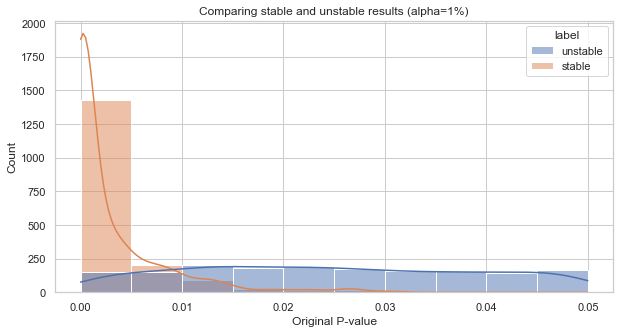

In [109]:
def get_stats(df):
    count = df['Original P-value'].describe()['count']
    mean = round(df['Original P-value'].describe()['mean'],4)
    std = round(df['Original P-value'].describe()['std'],4)
    min = round(df['Original P-value'].describe()['min'],4)
    max = round(df['Original P-value'].describe()['max'],4)
    print(f'count: {count}, mean: {mean}, std:{std}, min: {min}, max: {max}')

print(f'Total tests: {len(df)}')
print(f'df_stable_pval:')
get_stats(df[mask_stable])
print(f'df_unstable_pval:')
get_stats(df[mask_unstable])

fig, axes = plt.subplots(1,1,figsize=(10,5))
axes.set_title("Comparing stable and unstable results (alpha=1%)")
# plot histogram to compare
sns.histplot(data=df, x="Original P-value",hue='label', kde=True,bins=10);


[]

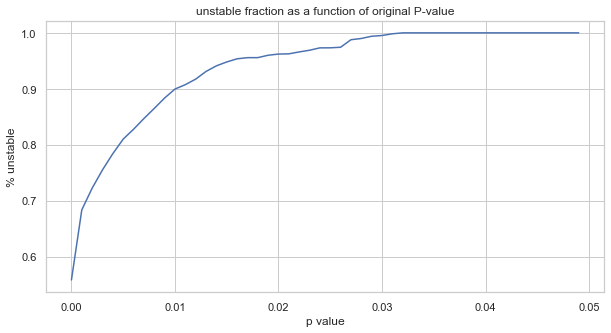

In [110]:
# Find unstable precent from all tests as a function of pvalue score
fig, axes = plt.subplots(1,1,figsize=(10,5))
axes.set_title("unstable fraction as a function of original P-value")
pvalue = np.arange(0,0.05,0.001)
unstable_percentage = []
for i in pvalue:
    df_temp_unstable = df[mask_unstable][df[mask_unstable]['Original P-value']>i]
    df_temp_stable = df[mask_stable][df[mask_stable]['Original P-value']>i]
    unstable_percentage.append(len(df_temp_unstable)/(len(df_temp_unstable)+len(df_temp_stable)))
plt.plot(pvalue,unstable_percentage)
plt.grid(True)
axes.set_xlabel("p value")
axes.set_ylabel("% unstable")
axes.plot()

In [119]:
fig = px.scatter(df[mask_unstable], x="Original P-value", y="p_value upper on alpha 0.01", color="cancer type",
                 color_discrete_map=color_dict,
                 hover_data=['cancer type'],range_x=[-0.001,0.051],title="unstable gene cases")
fig.add_hline(y=0.05,line_dash='dash',line_color='red')
fig.show()


In [120]:
fig = px.scatter(df[mask_stable], x="Original P-value", y="p_value upper on alpha 0.01", color="cancer type",
                 color_discrete_map=color_dict,
                 hover_data=['cancer type'],range_x=[-0.001,0.03],title="stable gene cases")
fig.add_hline(y=0.05,line_dash='dash',line_color='red')
fig.show()


[]

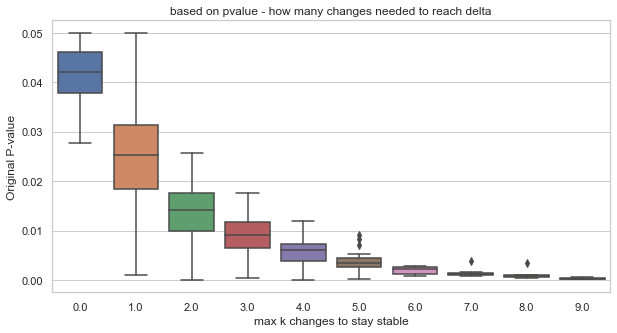

In [121]:
fig, axes = plt.subplots(1,1,figsize=(10,5))
axes.set_title("based on pvalue - how many changes needed to reach delta")
sns.boxplot(x='max k changes to stay stable', y='Original P-value', data=df[mask_unstable])
axes.plot()

[]

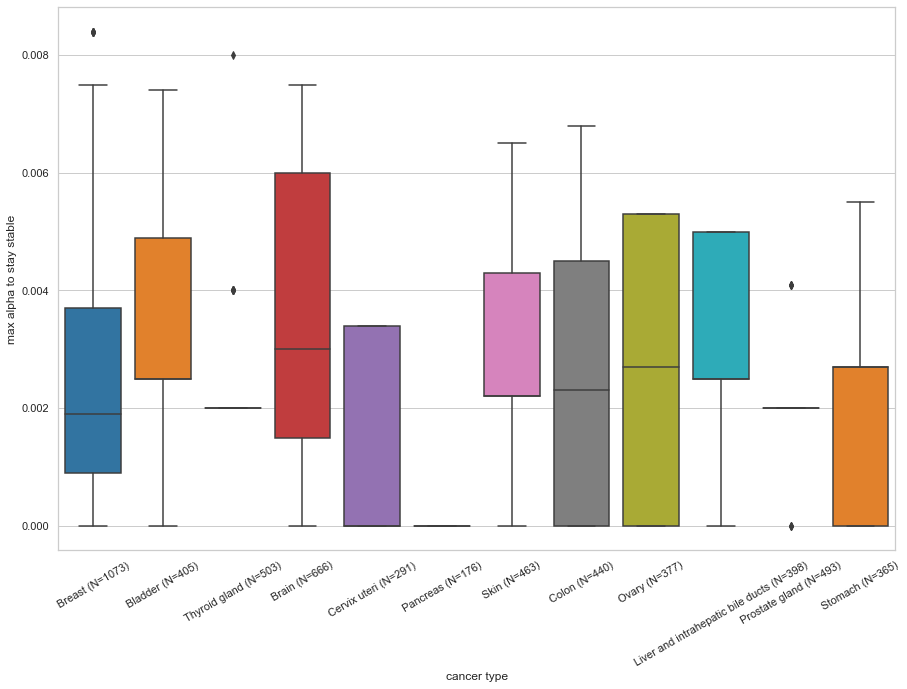

In [122]:
fig, axes = plt.subplots(1,1,figsize=(15,10))
axes.set_title("")
sns.boxplot(x='cancer type', y='max alpha to stay stable', data=df[mask_unstable],palette=color_dict_sns)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 30)
axes.plot()

[]

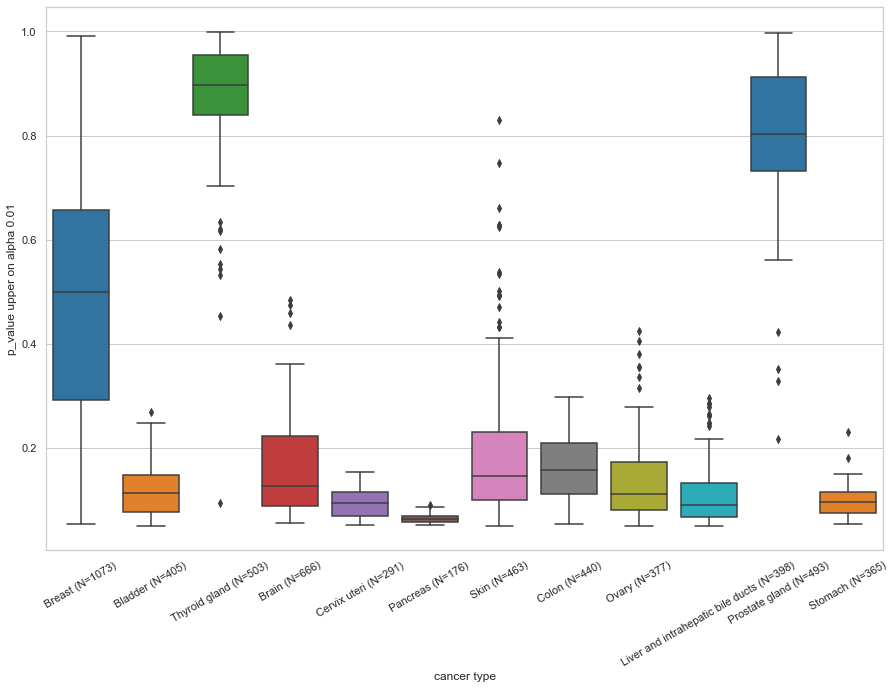

In [132]:
fig, axes = plt.subplots(1,1,figsize=(15,10))
axes.set_title("")
ax = sns.boxplot(x='cancer type', y='p_value upper on alpha 0.01', data=df[mask_unstable],palette=color_dict_sns)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 30)
axes.plot()


In [131]:
print(len(df[df["p_value upper one change"]>0.05]))
print(len(df[df["p_value upper one change"]>0.05])/len(df))
print(len(df[mask_unstable][df[mask_unstable]["p_value upper one change"]>0.05])/len(df[mask_unstable][df[mask_unstable]["Original P-value"]>0.03]))

fig = px.scatter(df, x="Original P-value", y="p_value upper one change", color="cancer type",
                 hover_data=['cancer type'],
                 range_x=[-0.001,0.05],
                 title="Applying one change on tests",)
fig.add_hline(y=0.05,line_dash='dash',line_color='red')
fig.show()

392
0.05079036019694221
0.6251993620414673


In [ ]:
df_report

In [87]:
# df_temp = df[(df['label']=='unstable') & (df['max k changes to stay stable']==1)]

# fig = px.scatter(df_temp, x="Original P-value", y="p_value upper with max changes k", color="cancer type",
#                  color_discrete_map=color_dict,hover_data=['cancer type'],range_x=[-0.001,0.05],
#                  title="All gene with K=1 max changes to stay stable")
# fig.show()

In [88]:
# df_temp = df[(df['label']=='unstable') & (df['max k changes to stay stable']==2)]
# fig = px.scatter(df_temp, x="Original P-value", y="p_value upper with max changes k", color="cancer type",
#                  color_discrete_map=color_dict,
#                  hover_data=['cancer type'],range_x=[-0.001,0.051],title="P upper on K=2")
# fig.show()


## greedy

### On df_unstable_pval

In [117]:
# all test that was aggrement between greedy and classic pvalue algo
df_greedy_pass = df[mask_unstable][df[mask_unstable]['is greedy algo correct up to alpha'] == True]
df_greedy_fail = df[mask_unstable][df[mask_unstable]['is greedy algo correct up to alpha'] == False]
print(f'df_greedy_pass:')
get_stats(df_greedy_pass)
print(f'df_greedy_fail:')
get_stats(df_greedy_fail)
df_greedy_fail[['cancer type','gene','Original P-value','num of samples','max k changes with chosen alpha','p_value upper on alpha 0.01','k changes to reach disagreement','p_value when disagreement']]
# TODO run on max K+1 on threshold 0.1 0.05 but not morethan alpha of 1%

df_greedy_pass:
count: 1665.0, mean: 0.0246, std:0.0141, min: 0.0, max: 0.05
df_greedy_fail:
count: 8.0, mean: 0.0422, std:0.0093, min: 0.0259, max: 0.0491


,cancer type,gene,Original P-value,num of samples,max k changes with chosen alpha,p_value upper on alpha 0.01,k changes to reach disagreement,p_value when disagreement
1411,Thyroid gland (N=503),FAP,0.046602,503,5.0,0.860293,5.0,0.753048
1427,Thyroid gland (N=503),PARP3,0.048460,503,5.0,0.857456,5.0,0.754554
1755,Thyroid gland (N=503),DLD,0.045478,503,5.0,0.842219,5.0,0.761248
1910,Thyroid gland (N=503),SDHC,0.049098,503,5.0,0.852778,5.0,0.751523
6662,Prostate gland (N=493),EGR1,0.025917,493,4.0,0.937340,4.0,0.701409
6753,Prostate gland (N=493),PIF1,0.048812,493,4.0,0.878000,4.0,0.791282
6921,Prostate gland (N=493),SOCS3,0.044765,493,4.0,0.825795,4.0,0.811762
7021,Prostate gland (N=493),NEIL3,0.028817,493,4.0,0.920522,4.0,0.721535


### On df_stable_pval

In [118]:
# all test that was aggrement between greedy and classic pvalue algo
df_greedy_pass = df[mask_stable][df[mask_stable]['is greedy algo correct up to alpha'] == True]
df_greedy_fail = df[mask_stable][df[mask_stable]['is greedy algo correct up to alpha'] == False]
print(f'df_greedy_pass:')
get_stats(df_greedy_pass)
print(f'df_greedy_fail:')
get_stats(df_greedy_fail)
df_greedy_fail[['cancer type','gene','Original P-value','num of samples','max k changes with chosen alpha','p_value upper on alpha 0.01','k changes to reach disagreement','p_value when disagreement']]

df_greedy_pass:
count: 1778.0, mean: 0.003, std:0.0051, min: 0.0, max: 0.0312
df_greedy_fail:
count: 6.0, mean: 0.0, std:0.0, min: 0.0, max: 0.0001


,cancer type,gene,Original P-value,num of samples,max k changes with chosen alpha,p_value upper on alpha 0.01,k changes to reach disagreement,p_value when disagreement
2094,Brain (N=666),BCL2,0.000000,666,6.0,3.106191e-09,6.0,0.000000
2120,Brain (N=666),TNFSF4,0.000000,666,6.0,6.236492e-10,6.0,0.000000
6007,Liver and intrahepatic bile ducts (N=398),CDC6,0.000003,398,3.0,5.149220e-05,3.0,0.000051
6036,Liver and intrahepatic bile ducts (N=398),RPIA,0.000006,398,3.0,7.329727e-05,NaN,NaN
6170,Liver and intrahepatic bile ducts (N=398),TKT,0.000038,398,3.0,4.504650e-04,3.0,0.000446
6307,Liver and intrahepatic bile ducts (N=398),SLX4,0.000105,398,3.0,1.073688e-03,3.0,0.001072


In [ ]:
# import os
# os.system(f"jupyter nbconvert Pancancer_report.ipynb --output reports/report --no-input --to webpdf --allow-chromium-download") 

In [ ]:
import os
os.system(f"jupyter nbconvert Pancancer_report.ipynb --output reports/report --no-input --to html --allow-chromium-download") 